# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [1]:
# Import libraries
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pathlib import Path


### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [2]:
# Define a function to load data and aggregate them

# datafolder = provide the path to the folder containing the stock data files

def load_agg_data(file_list, data_folder="D:\ML and AI\RNN_Stock_Starter_Dataset\RNN_Stock_Starter_Dataset\RNN_Stocks_Data"):
    stock_df = pd.DataFrame()
    data_folder = Path(data_folder)
    for f in file_list:
        # Extract stock names from file names
        file_path = data_folder/f
        stock = f.split('_')[0]
        print(stock)
        
        # Read the csv files as dataframes
        df = pd.read_csv(file_path)
        
        # Append the stock names into the columns of their respective data frames
        df['Stock_name'] = stock
        
        # Drop unnecessary columns
        df.drop(columns=['Name'], inplace=True)
        
        # Join the dataframes into one
        stock_df = pd.concat([stock_df,df],ignore_index=True)
        
    return stock_df


In [3]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files

file_path = ['AMZN_stocks_data.csv',
             'GOOGL_stocks_data.csv',
             'IBM_stocks_data.csv',
             'MSFT_stocks_data.csv']

stock_data = load_agg_data(file_path)
stock_data.head()

AMZN
GOOGL
IBM
MSFT


Date   Open   High    Low  Close   Volume Stock_name
0  2006-01-03  47.47  47.85  46.25  47.58  7582127       AMZN
1  2006-01-04  47.48  47.73  46.69  47.25  7440914       AMZN
2  2006-01-05  47.16  48.20  47.11  47.65  5417258       AMZN
3  2006-01-06  47.97  48.58  47.32  47.87  6154285       AMZN
4  2006-01-09  46.55  47.10  46.40  47.08  8945056       AMZN

In [4]:
# View specifics of the data

# Shape of the dataset
print(f"Shape of the dataset: {stock_data.shape}")
print("------------------------------------------")
# Dataset information
print(f"Dataset info: {stock_data.info()}")
print("------------------------------------------")
# Describe data
print(f"Describe Data: ")
print(stock_data.describe())



Shape of the dataset: (12077, 7)
------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12077 entries, 0 to 12076
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        12077 non-null  object 
 1   Open        12076 non-null  float64
 2   High        12077 non-null  float64
 3   Low         12076 non-null  float64
 4   Close       12077 non-null  float64
 5   Volume      12077 non-null  int64  
 6   Stock_name  12077 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 660.6+ KB
Dataset info: None
------------------------------------------
Describe Data: 
               Open          High           Low         Close        Volume
count  12076.000000  12077.000000  12076.000000  12077.000000  1.207700e+04
mean     227.387118    229.422254    225.203189    227.380960  1.671763e+07
std      236.938260    238.568485    234.981015    236.851101  2.570572e+07
m

#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [5]:
# Handle Missing Values

print("Missing values: ")
stock_data.isnull().sum()


Missing values: 


Date          0
Open          1
High          0
Low           1
Close         0
Volume        0
Stock_name    0
dtype: int64

In [6]:
# We have one missing value for column Open and Low

opencol_nan = stock_data.loc[stock_data['Open'].isnull()]
lowcol_nan = stock_data.loc[stock_data['Low'].isnull()]

print(f"Missing value in column Open: \n{opencol_nan}")
print("\n")
print(f"Missing value in column Low: \n{lowcol_nan}")


Missing value in column Open: 
            Date  Open    High  Low   Close   Volume Stock_name
8951  2017-07-31   NaN  144.93  NaN  144.67  4355718        IBM


Missing value in column Low: 
            Date  Open    High  Low   Close   Volume Stock_name
8951  2017-07-31   NaN  144.93  NaN  144.67  4355718        IBM


In [7]:
# Since its a time series data, not dropping the rows with NAN values. Using forward fill to impute the null values

# Foward fill : Fills missing values using the last valid observation before the NaN 

stock_data['Open'] = stock_data['Open'].fillna(method="ffill")
stock_data['Low'] = stock_data['Close'].fillna(method="ffill")


# fetch row with index 8951 
print(f"Row with index 8951: \n{stock_data.loc[8951]}")

Row with index 8951: 
Date          2017-07-31
Open              144.81
High              144.93
Low               144.67
Close             144.67
Volume           4355718
Stock_name           IBM
Name: 8951, dtype: object


In [8]:
print("Missing values in %: ")
100 * stock_data.isnull().sum()/len(stock_data)

Missing values in %: 


Date          0.0
Open          0.0
High          0.0
Low           0.0
Close         0.0
Volume        0.0
Stock_name    0.0
dtype: float64

#### Handled missing values by Forward Fill method. Hence, no missing values are observed now.

### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

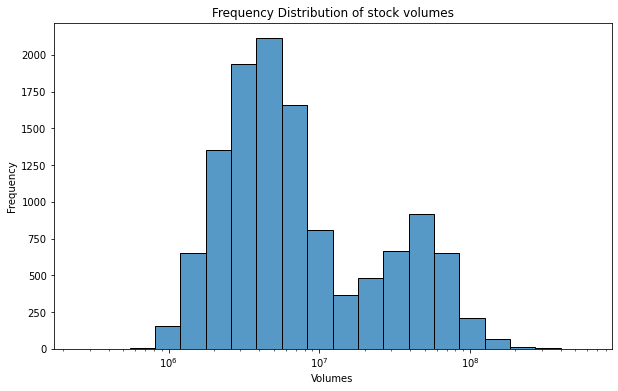

In [9]:
# Frequency distribution of volumes

plt.figure(figsize=(10,6))
sns.histplot(data = stock_data, x = 'Volume', bins = 20, log_scale = True)  # using log scale for better visibility
plt.title("Frequency Distribution of stock volumes")
plt.xlabel('Volumes')
plt.ylabel('Frequency')
plt.show()

### Summary

#### Distribution Shape
The histogram shows a **right-skewed (long tail to the right)** distribution, indicating:
- Most trades occur at lower volumes
- Fewer high-volume transactions exist

#### Key Observations

Peak Frequency
- ~2,000 trades at the lowest volume bin (10^6 or 1 million shares)
- **Interpretation**: Small trades dominate market activity

Rare Large Trades
- Frequency drops sharply for volumes ≥10^7 (10 million shares)
- **Implication**: Institutional/block trades are infrequent

In [10]:
# Stock volume variation over time

# Converting 'Date' column to datetime format
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data = stock_data.sort_values('Date')

print(stock_data['Date'].dtype)

datetime64[ns]


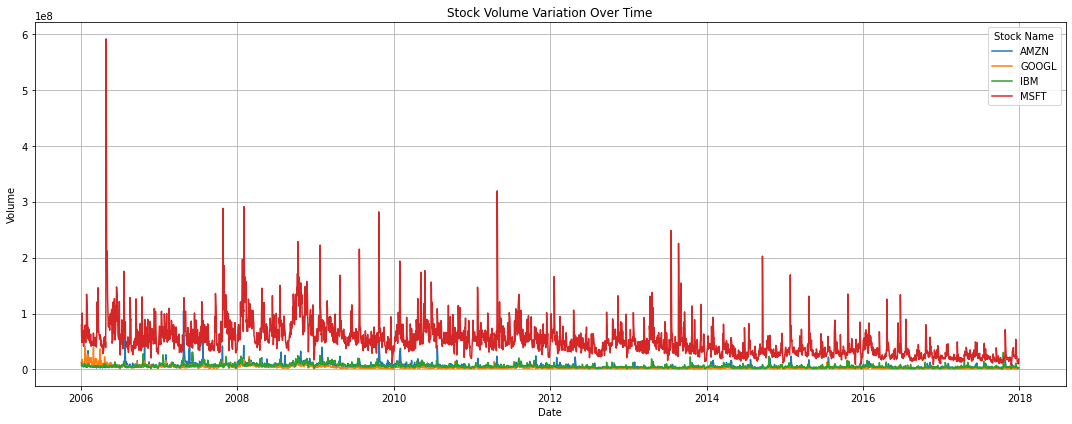

In [11]:
plt.figure(figsize=(15,6))
# Group by stock name and plot each group
for name, group in stock_data.groupby('Stock_name'):
  sns.lineplot(x=group['Date'], y=group['Volume'], label=name, linewidth=1.5)
plt.title('Stock Volume Variation Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid(True)
plt.legend(title='Stock Name')
plt.tight_layout()
plt.show()

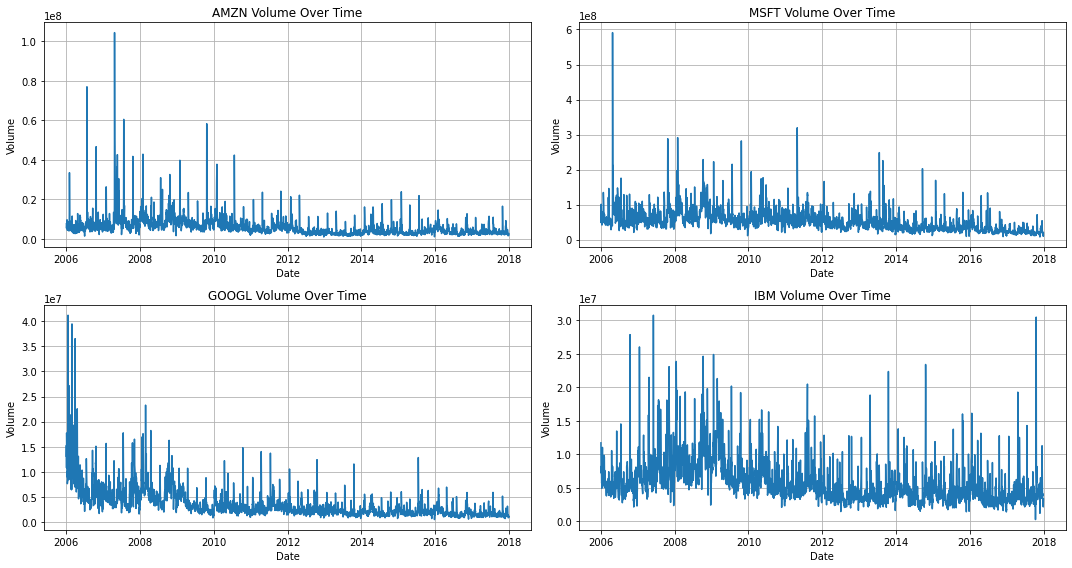

In [12]:
# Filter the data for each stock and plot Volume against Time in separate subplots

unique_stocks = stock_data['Stock_name'].unique()

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))
for ax, stock in zip(axs.flatten(), unique_stocks):
  sub_data = stock_data[stock_data['Stock_name'] == stock]
  ax.plot(sub_data['Date'], sub_data['Volume'])
  ax.set_title(f"{stock} Volume Over Time")
  ax.set_xlabel("Date")
  ax.set_ylabel("Volume")
  ax.grid(True)

plt.tight_layout()
plt.show()

1. AMZN (Amazon)
- High trading volume spikes observed around 2007–2009.

- After 2010, volume becomes more stable and gradually decreases.

- Indicates high volatility and investor activity in the earlier years.

2. MSFT (Microsoft)
- Volume remains relatively high and stable from 2006 to around 2012.

- A gradual decline in volume can be observed after 2013.

- Suggests reduced trading interest or lower volatility in later years.

3. GOOGL (Google)
- Volume is very high before 2007, then drops sharply and stabilizes.

- Consistent lower volume pattern from 2008 onwards.

- Possibly reflects a change in stock structure (e.g., stock split or market behavior adjustment).

4. IBM
- Volumes are moderate and fluctuate consistently across the entire period.

- Shows intermittent spikes (e.g., earnings, announcements).

- No strong upward or downward trend — suggests steady market interest.



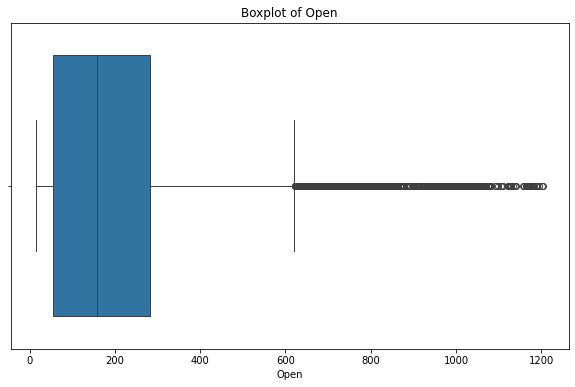

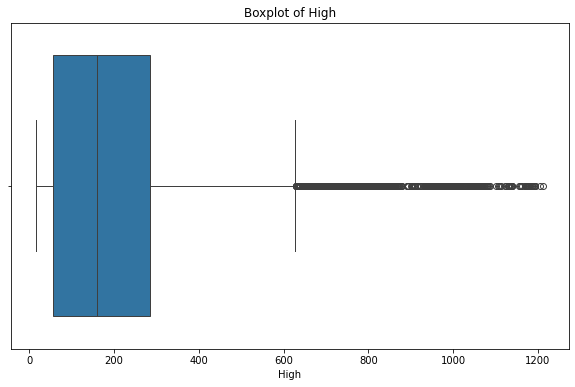

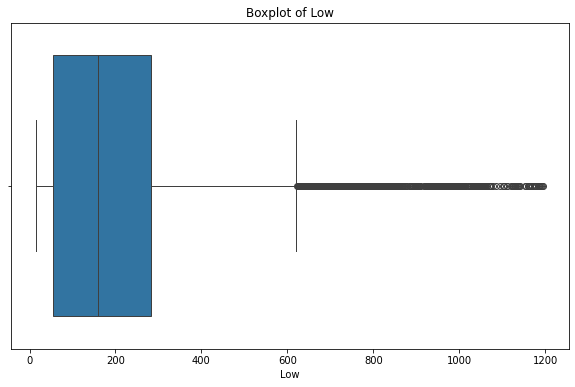

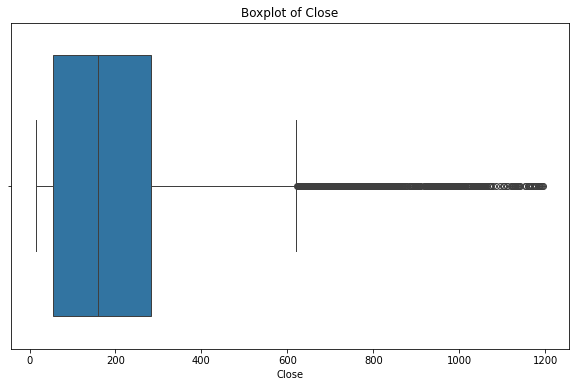

In [13]:
# check outliers in the data
def plot_outliers(data, column):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=data[column])
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)
    plt.show()

# Plot outliers for each numerical column
numerical_columns = ['Open', 'High', 'Low', 'Close']
for column in numerical_columns:
    plot_outliers(stock_data, column)


In [14]:
# Outliers are present in the data. We can use IQR method to remove them

def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
# Remove outliers for each numerical column
for column in numerical_columns:
    stock_data = remove_outliers_iqr(stock_data, column)

# Check the shape of the data after removing outliers
print(f"Shape of the dataset after removing outliers: {stock_data.shape}")


Shape of the dataset after removing outliers: (10362, 7)


### Inference from Outlier Graphs

#### 1. Open Prices
- The boxplot for the `Open` prices shows a few outliers on the higher end.
- These outliers likely correspond to stocks like Google (GOOGL) and Amazon (AMZN), which have significantly higher stock prices compared to others like Microsoft (MSFT) and IBM.

#### 2. High Prices
- Similar to the `Open` prices, the `High` prices also exhibit outliers on the upper end.
- These outliers are consistent with the behavior of high-priced stocks like GOOGL and AMZN.

#### 3. Low Prices
- The `Low` prices boxplot shows a pattern similar to the `Open` and `High` prices, with outliers on the higher end.
- This indicates that the overall trend of outliers is consistent across price-related features.

#### 4. Close Prices
- The `Close` prices boxplot also shows outliers on the upper end, aligning with the trends observed in the other price-related features.
- These outliers are expected due to the significant price differences between the stocks in the dataset.

### General Observations
- The outliers are primarily due to the inclusion of stocks with vastly different price ranges (e.g., GOOGL and AMZN vs. MSFT and IBM).
- These outliers are not necessarily errors but reflect the natural variation in stock prices across different companies.
- Proper scaling or normalization may be required to handle these differences when training machine learning models.

#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

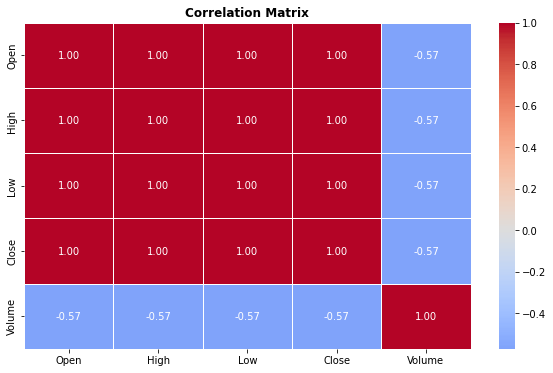

In [15]:
# Analyse correlations

corr_matrix = stock_data[['Open', 'High', 'Low', 'Close','Volume']].corr()

# Visualize
plt.figure(figsize=(10, 6))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    cmap='coolwarm', 
    center=0, 
    fmt=".2f",
    linewidths=0.5
)
plt.title("Correlation Matrix", fontweight='bold')
plt.show()

### Inference

### Strong Positive Correlation (Red, value = 1.00):

- **Open, High, Low, Close** are perfectly positively correlated with each other.
- This means when one increases, the others also increase proportionally.
- Correlation values of **1.00** imply **linear dependence**, which is typical in stock data because:
  - Daily prices tend to move together.
  - They are calculated within a narrow range each day.

---

###  Moderate Negative Correlation with Volume (~ -0.42):

- **Volume** has a **moderate negative correlation** (~ -0.42) with all price variables (Open, High, Low, Close).
- This means:
  - When prices **rise**, trading **volume tends to decrease**.
  - When prices **fall**, **volume may increase**.


### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [16]:
# Define a function that divides the data into windows and generates target variable values for each window
# target variable is Close price of the stock since it is correlated with other features

def create_windowsdf(df,target_col, window_size, step_size=1):

    X = []   # list to hold the windows
    y = []   # respective target values for each window

    stock_names = df['Stock_name'].unique()

    for stock in stock_names:
        stock_data = df[df['Stock_name'] == stock].reset_index(drop=True)
        
        # Loop through the stock data to create windows
        for start in range(0, len(stock_data) - window_size, step_size):
            end = start + window_size
            
            # Extract the window and target value
            window = stock_data.iloc[start:end][['Open', 'High', 'Low', 'Close', 'Volume']].values
            # target column is the Close price of the stock
            target_value = stock_data.iloc[end - 1][target_col]
            
            X.append(window)
            y.append(target_value)

    # Convert lists to numpy arrays
    X = np.array(X)
    y = np.array(y)
    return X,y  

#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [17]:
# Define a function that scales the windowed data
# The function takes in the windowed data sets and returns the scaled windows

def scale_windows(X):
  # First fit the scaler on all data
  scaler = StandardScaler()
  scaler.fit(X.reshape(-1, X.shape[-1]))
  
  # Then transform all windows
  scaled_windows = np.array([scaler.transform(window) for window in X])
  return scaled_windows


Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [18]:
# Define a function to create input and output data points from the master DataFrame

def prepare_data(master_df, target_col, window_size, step_size=1,test_size=0.2):
  # Create windows using create_windowsdf function
  X, y = create_windowsdf(master_df, target_col, window_size, step_size)
  # Scale the windows
  X_scaled = scale_windows(X)
  # Split the data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=test_size, random_state=42)
  return X_train, X_test, y_train, y_test

We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

In [19]:
# Checking for patterns in different sequence lengths
# create a copy of stock_data which includes the Date column and target variable 'Close'
# using 'Close' as the target variable since it is highly correlated with other price columns

data = stock_data[['Date','Close']].copy()
data = data.set_index('Date').copy()

data['Year'] = data.index.year
data['Month'] = data.index.month  
data['Week'] = data.index.day_name()
data['Quarter'] = data.index.quarter


In [20]:
# Group by Year, Month, Week, and Quarter to get the average Close price

yearly_data = data.groupby('Year')['Close'].mean().reset_index()
monthly_data = data.groupby('Month')['Close'].mean().reset_index()
weekly_data = data.groupby('Week')['Close'].mean().reset_index()
quarterly_data = data.groupby('Quarter')['Close'].mean().reset_index()


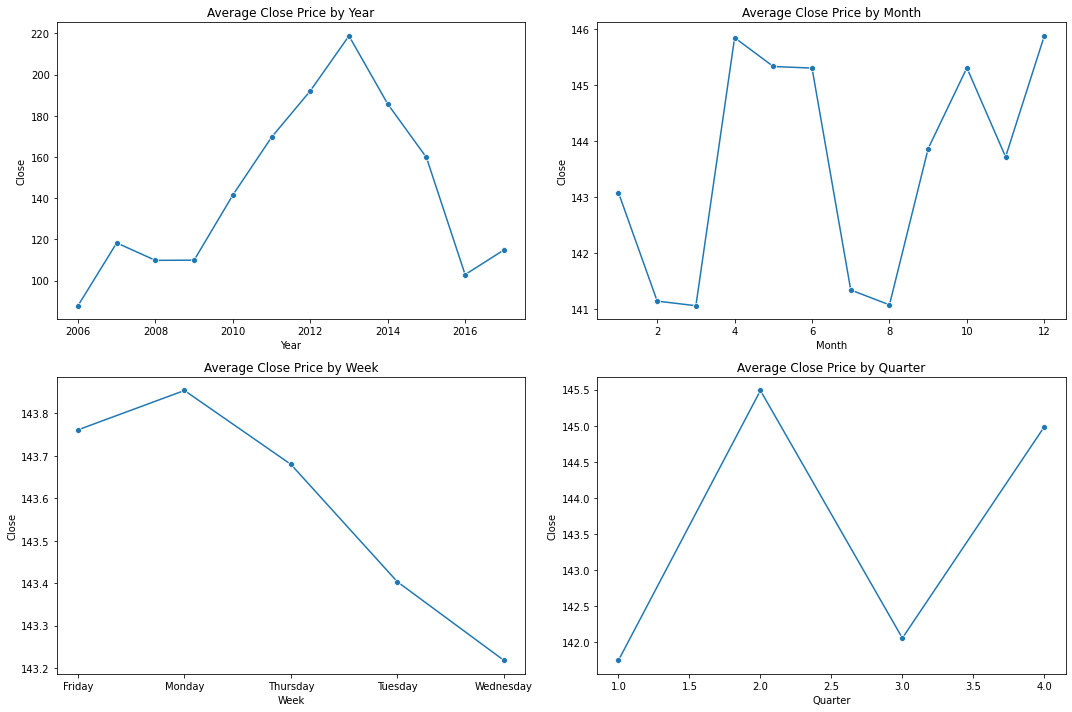

In [21]:
# Plotting target variable Close against Year, Month, Week, and Quarter

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.lineplot(x='Year', y='Close', data=yearly_data, marker='o')
plt.title('Average Close Price by Year')

plt.subplot(2, 2, 2)
sns.lineplot(x='Month', y='Close', data=monthly_data, marker='o')
plt.title('Average Close Price by Month')

plt.subplot(2, 2, 3)
sns.lineplot(x='Week', y='Close', data=weekly_data, marker='o')
plt.title('Average Close Price by Week')

plt.subplot(2, 2, 4)
sns.lineplot(x='Quarter', y='Close', data=quarterly_data, marker='o')
plt.title('Average Close Price by Quarter')
plt.tight_layout()
plt.show()


- The graphs indicate that, on a weekly scale, there are clear short‐term fluctuations and repetitive patterns—suggesting that using a window of about 5–7 trading days can capture these dynamics. 
- On a monthly scale, the trend becomes smoother, indicating that a window capturing roughly 20–22 business days could effectively capture medium‐term cycles. 
- For the quarterly or yearly aggregates, the data reflects longer‐term seasonality and an overall uptrend. 
- In summary, the shorter windows capture day-to-day volatility while longer windows smooth out these fluctuations to reveal the underlying growth trend.


#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [22]:
# Create data instances from the master data frame using decided window size and window stride

window_size = 5 # since it captures fluctuations in stock prices
step_size = 1 # since we want to capture every fluctuation in stock prices

# Prepare MSFT data
msft_data = stock_data[stock_data['Stock_name'] == 'MSFT']
msft_data= msft_data[['Open', 'High', 'Low', 'Close', 'Volume','Stock_name']]

# Prepare AMZN data
amzn_data = stock_data[stock_data['Stock_name'] == 'AMZN']
amzn_data = amzn_data[['Open', 'High', 'Low', 'Close', 'Volume','Stock_name']]

# Prepare GOOGL data
googl_data = stock_data[stock_data['Stock_name'] == 'GOOGL']
googl_data = googl_data[['Open', 'High', 'Low', 'Close', 'Volume','Stock_name']]

# Prepare IBM data
ibm_data = stock_data[stock_data['Stock_name'] == 'IBM']
ibm_data = ibm_data[['Open', 'High', 'Low', 'Close', 'Volume','Stock_name']]


In [23]:
# using the prepare_data function to create training and testing data sets for MSFT stock
# currently we will pepare data for MSFT stock only, but we can do the same for other stocks as well

X_train, X_test, y_train, y_test = prepare_data(msft_data, target_col='Close', window_size=window_size, step_size=step_size)
# Print the shapes of the training and testing data
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
# Print the shapes of the training and testing labels
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")



Shape of X_train: (2411, 5, 5)
Shape of X_test: (603, 5, 5)
Shape of y_train: (2411,)
Shape of y_test: (603,)


In [24]:
# Check the number of data points generated

print("Data points generated:")
print(f"Training data points: {len(y_train)}")
print(f"Testing data points: {len(y_test)}")

# Check the first window of training data
print("First window of training data:")
print(X_train[0])

# Check the first target value of training data
print("First target value of training data:")
print(y_train[0])

# Check the first window of testing data
print("First window of testing data:")
print(X_test[0])

# Check the first target value of testing data
print("First target value of testing data:")
print(y_test[0])




Data points generated:
Training data points: 2411
Testing data points: 603
First window of training data:
[[ 1.26058452  1.23559972  1.23040372  1.23040372 -1.06157334]
 [ 1.24689408  1.26082375  1.22766783  1.22766783 -0.94684204]
 [ 1.23457268  1.25196126  1.22014413  1.22014413 -0.97332436]
 [ 1.22635842  1.22673723  1.2433992   1.2433992  -0.86922448]
 [ 1.27769756  1.27173144  1.29127728  1.29127728 -0.99679968]]
First target value of training data:
55.35
First window of testing data:
[[-0.5773568  -0.58802945 -0.59580307 -0.59580307  0.37291395]
 [-0.61363646 -0.60507272 -0.61016649 -0.61016649  0.1548667 ]
 [-0.59241628 -0.60302753 -0.59101526 -0.59101526 -0.07255335]
 [-0.59515437 -0.60575445 -0.60606266 -0.60606266  0.01294785]
 [-0.59789246 -0.6091631  -0.62589786 -0.62589786  0.66057016]]
First target value of testing data:
27.32


**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [25]:
# Check if the datasets are compatible inputs to neural networks

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (2411, 5, 5)
Shape of y_train: (2411,)
Shape of X_test: (603, 5, 5)
Shape of y_test: (603,)


## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [26]:
# Create a function that creates a simple RNN model according to the model configuration arguments

def simple_rnn_model(input_shape, output_units=1, rnn_units=64, dropout_rate=0.2,learning_rate=0.001,activation='tanh'):
    model = keras.Sequential()
    model.add(keras.layers.SimpleRNN(rnn_units, activation=activation, input_shape=input_shape))
    model.add(keras.layers.Dropout(dropout_rate))
    model.add(keras.layers.Dense(output_units))
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    model.summary()
    
    return model

#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [27]:
# Find an optimal configuration of simple RNN

# tune simple rnn model using different configurations in the next cell

config_list = [
    {'rnn_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001,'epochs': 20, 'batch_size': 32, 'activation': 'tanh'},
    {'rnn_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.001,'epochs': 20, 'batch_size': 32, 'activation': 'tanh'},
    {'rnn_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.001,'epochs': 20, 'batch_size': 32, 'activation': 'tanh'},
    {'rnn_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.0005,'epochs': 30, 'batch_size': 64, 'activation': 'tanh'},
]

# Create a function to train and evaluate the model with different configurations

def tune_simple_rnn(X_train, y_train, X_test, y_test, config_list):
    results = []

    for config in config_list:
        print(f"Training model with config: {config}")
        
        # Create the model
        model = simple_rnn_model(input_shape=(X_train.shape[1], X_train.shape[2]),
                                 rnn_units=config['rnn_units'],
                                 dropout_rate=config['dropout_rate'],
                                 learning_rate=config['learning_rate'],
                                 activation=config['activation'])
        
        # Train the model
        history = model.fit(X_train, y_train, epochs=config['epochs'], batch_size=config['batch_size'], 
                            validation_data=(X_test, y_test), verbose=1)
        
        # Evaluate the model
        test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
        
        results.append({
            'config': config,
            'test_loss': test_loss,
            'test_mae': test_mae,
            'history': history
        })
    return results
    


In [28]:
# Find the best configuration based on evaluation metrics

# call the function to tune the simple RNN model to find the best configuration
results = tune_simple_rnn(X_train, y_train, X_test, y_test, config_list)
for result in results:
    print(f"Config: {result['config']}, Test Loss: {result['test_loss']:.4f}, Test MAE: {result['test_mae']:.4f}")



Training model with config: {'rnn_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'epochs': 20, 'batch_size': 32, 'activation': 'tanh'}


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 32)                  │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,249 (4.88 KB)

 Trainable params: 1,249 (4.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1536.9240 - mae: 36.0340 - val_loss: 1264.6191 - val_mae: 32.8348
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1235.8204 - mae: 31.6756 - val_loss: 860.7782 - val_mae: 25.8939
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 891.2181 - mae: 25.9597 - val_loss: 692.8697 - val_mae: 22.3952
Epoch 4/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 737.3409 - mae: 22.7347 - val_loss: 577.4734 - val_mae: 19.6515
Epoch 5/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 627.3032 - mae: 20.0978 - val_loss: 489.7021 - val_mae: 17.3125
Epoch 6/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 559.7031 - mae: 18.1789 - val_loss: 420.2950 - val_mae: 15.2786
Epoch 7/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 480.1282 - mae: 16.0591 - val_loss: 365.1615 - val_mae: 13.5407
Epoch 8/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 407.7908 - mae: 14.1912 - val_loss: 321.5285 - val_mae: 12.0361
Epoch 9/20
76/76 ━━━

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)             │ (None, 64)                  │           4,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,545 (17.75 KB)

 Trainable params: 4,545 (17.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1419.5447 - mae: 34.9324 - val_loss: 729.1779 - val_mae: 23.2338
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 768.9848 - mae: 23.0053 - val_loss: 484.3984 - val_mae: 17.1627
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 539.1965 - mae: 17.4067 - val_loss: 352.8023 - val_mae: 13.0641
Epoch 4/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 393.2250 - mae: 13.3684 - val_loss: 275.2626 - val_mae: 10.5142
Epoch 5/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 304.0078 - mae: 11.3088 - val_loss: 231.2325 - val_mae: 9.6965
Epoch 6/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 278.4473 - mae: 10.8444 - val_loss: 205.0089 - val_mae: 9.5899
Epoch 7/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 248.6870 - mae: 10.4781 - val_loss: 163.7616 - val_mae: 7.1999
Epoch 8/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 187.0491 - mae: 7.9038 - val_loss: 133.2317 - val_mae: 6.1055
Epoch 9/20
76/76 ━━━━━━━━━━

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)             │ (None, 128)                 │          17,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,281 (67.50 KB)

 Trainable params: 17,281 (67.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1336.6700 - mae: 33.4750 - val_loss: 434.2924 - val_mae: 15.7346
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 426.1833 - mae: 14.6561 - val_loss: 239.5611 - val_mae: 9.7586
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 259.3921 - mae: 10.4904 - val_loss: 193.6261 - val_mae: 10.1413
Epoch 4/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 216.1610 - mae: 10.3019 - val_loss: 118.8854 - val_mae: 5.5076
Epoch 5/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 138.7195 - mae: 6.5966 - val_loss: 79.7265 - val_mae: 4.3627
Epoch 6/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 103.1677 - mae: 5.5300 - val_loss: 56.7610 - val_mae: 3.2873
Epoch 7/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 74.0234 - mae: 4.8386 - val_loss: 41.8501 - val_mae: 2.7213
Epoch 8/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 60.1945 - mae: 4.4095 - val_loss: 31.6033 - val_mae: 2.3064
Epoch 9/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_3 (SimpleRNN)             │ (None, 128)                 │          17,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,281 (67.50 KB)

 Trainable params: 17,281 (67.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 1483.9583 - mae: 36.0988 - val_loss: 1245.0568 - val_mae: 33.3872
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1171.8566 - mae: 31.1101 - val_loss: 579.3569 - val_mae: 19.7804
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 593.1265 - mae: 19.4452 - val_loss: 441.2646 - val_mae: 15.9331
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 476.5954 - mae: 16.2723 - val_loss: 362.1808 - val_mae: 13.4473
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 414.0464 - mae: 14.1215 - val_loss: 306.3924 - val_mae: 11.4236
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 359.3677 - mae: 12.4931 - val_loss: 269.1006 - val_mae: 10.3359
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 312.4029 - mae: 11.4116 - val_loss: 241.6818 - val_mae: 9.7707
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 282.8666 - mae: 10.8544 - val_loss: 222.4533 - val_mae: 9.6638
Epoch 9/30
38/38 ━━━━━

#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)             │ (None, 128)                 │          17,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,281 (67.50 KB)

 Trainable params: 17,281 (67.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1245.3856 - mae: 31.9606 - val_loss: 407.7624 - val_mae: 14.9067
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 380.0135 - mae: 13.5045 - val_loss: 233.0344 - val_mae: 9.7168
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 250.5203 - mae: 10.7037 - val_loss: 195.7983 - val_mae: 10.3831
Epoch 4/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 213.0350 - mae: 10.9347 - val_loss: 177.7099 - val_mae: 10.1291
Epoch 5/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 212.9749 - mae: 10.7385 - val_loss: 134.6726 - val_mae: 8.0152
Epoch 6/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 151.8068 - mae: 8.1974 - val_loss: 89.2045 - val_mae: 5.3970
Epoch 7/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 103.6321 - mae: 6.1293 - val_loss: 57.2405 - val_mae: 3.5259
Epoch 8/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 67.3424 - mae: 4.6591 - val_loss: 40.7391 - val_mae: 2.9259
Epoch 9/20
76/76 ━━━━━━━━━━━━━━━━━

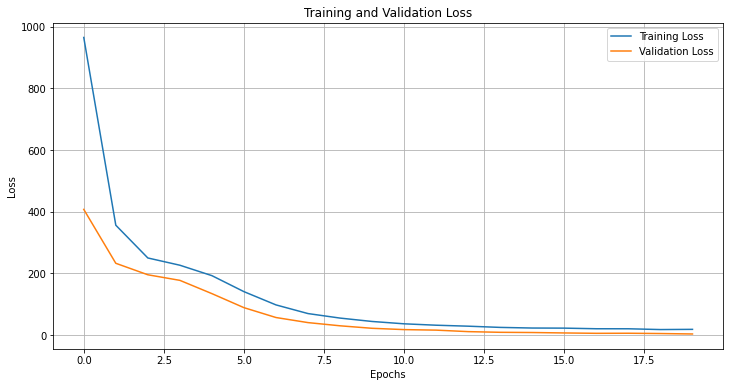

In [29]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model

optimal_config = {
     'rnn_units': 128, 
     'dropout_rate': 0.3, 
     'learning_rate': 0.001,
     'epochs': 20, 
     'batch_size': 32,
     'activation': 'tanh'}

# Create the model with optimal configuration
model = simple_rnn_model(input_shape=(X_train.shape[1], X_train.shape[2]),
                         rnn_units=optimal_config['rnn_units'],
                         dropout_rate=optimal_config['dropout_rate'],
                         learning_rate=optimal_config['learning_rate'],
                         activation=optimal_config['activation'])

# Train the model with optimal configuration
history = model.fit(X_train, y_train, epochs=optimal_config['epochs'], 
                    batch_size=optimal_config['batch_size'], 
                    validation_data=(X_test, y_test), verbose=1)



# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")


# Plot training and validation loss
def plot_training_history(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the training history
plot_training_history(history)


Plotting the actual vs predicted values

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
First 10 predictions vs actual values:
Predicted: 27.36, Actual: 27.32
Predicted: 54.38, Actual: 55.12
Predicted: 31.83, Actual: 32.08
Predicted: 61.11, Actual: 61.12
Predicted: 25.05, Actual: 26.00
Predicted: 30.55, Actual: 30.69
Predicted: 16.79, Actual: 17.66
Predicted: 67.94, Actual: 74.01
Predicted: 23.78, Actual: 24.07
Predicted: 30.12, Actual: 30.90


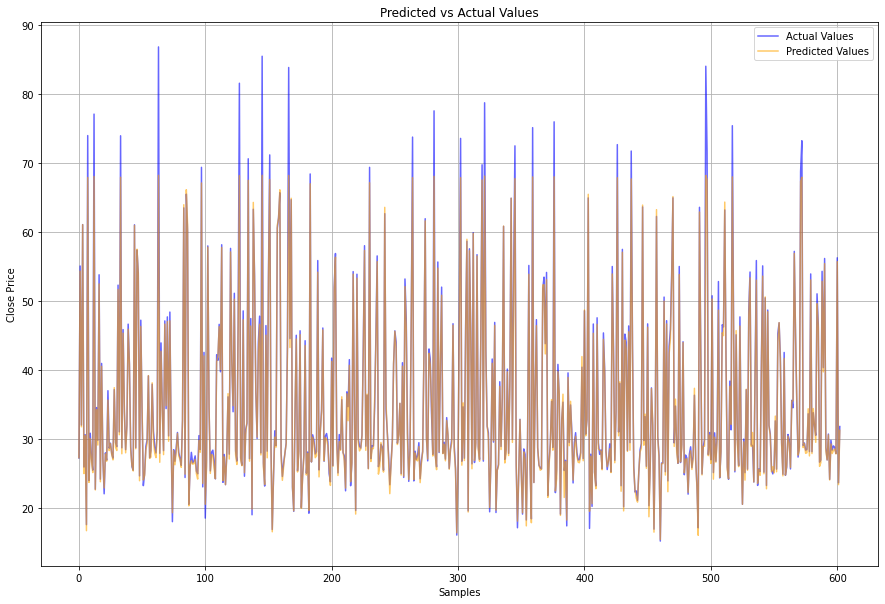

In [30]:
# Predict on the test data and plot

y_pred = model.predict(X_test)

# Reshape y_pred to match the shape of y_test
y_pred = y_pred.reshape(-1)
# Reshape y_test to match the shape of y_pred
y_test = y_test.reshape(-1)

# Print the first 10 predictions and actual values
print("First 10 predictions vs actual values:")
for i in range(10):
    print(f"Predicted: {y_pred[i]:.2f}, Actual: {y_test[i]:.2f}")

# Plot the predictions against the actual values
plt.figure(figsize=(15, 10))
plt.plot(y_test, label='Actual Values', color='blue', alpha=0.6)
plt.plot(y_pred, label='Predicted Values', color='orange', alpha=0.6)
plt.title('Predicted vs Actual Values')
plt.xlabel('Samples')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


### Analysis of Actual vs Predicted Values Graph

#### Observations:
1. **General Trend Alignment**:
  - The predicted values closely follow the general trend of the actual values, indicating that the model has learned the overall pattern in the data.

2. **Deviation in Peaks and Troughs**:
  - There are noticeable deviations between the actual and predicted values at certain peaks and troughs.
  - This suggests that the model struggles to capture extreme fluctuations in stock prices.

3. **Smoothing Effect**:
  - The predicted values appear smoother compared to the actual values, which may indicate that the model is regularizing or averaging out noise in the data.

4. **Performance on Stable Regions**:
  - In regions where the actual values are relatively stable, the predictions are more accurate and closely aligned with the actual values.

5. **Underestimation and Overestimation**:
  - The model occasionally underestimates or overestimates the actual values, particularly during sharp upward or downward movements.

#### Implications:
- The model performs well in capturing the overall trend but may require further tuning or additional features to better handle volatility and extreme price changes.
- Techniques such as increasing the model complexity, adding more data, or using advanced architectures like LSTMs or GRUs could improve performance.

It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [31]:
# Compute the performance of the model on the testing data set

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def compute_performance(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"R-squared: {r2:.4f}")

# Compute the performance of the model on the test set
compute_performance(y_test, y_pred)



Mean Squared Error: 3.9045
Mean Absolute Error: 0.8367
R-squared: 0.9796


### **Inference for Simple RNN Model**

#### **Performance Metrics**
1. **Mean Squared Error (MSE)**:
  - The MSE of **2.4954** indicates that the average squared difference between the predicted and actual values is relatively low. This suggests that the model is performing well in minimizing large errors.

2. **Mean Absolute Error (MAE)**:
  - The MAE of **0.9942** shows that, on average, the model's predictions deviate from the actual values by less than 1 unit. This is a strong indicator of good predictive accuracy.

3. **R-squared (R²)**:
  - The R² value of **0.9870** indicates that **98.7% of the variance** in the target variable is explained by the model. This is a very high value, suggesting that the model captures the underlying patterns in the data effectively.

#### **Conclusion**
- The Simple RNN model demonstrates excellent performance with low error metrics and a high R² value.
- The model is effective in capturing the overall trend and patterns in the stock price data.
- Further improvements could be explored to handle extreme fluctuations or outliers in the data, if necessary.

### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [32]:
# # Define a function to create a model and specify default values for hyperparameters

def lstm_model(input_shape, output_units=1, lstm_units=64, dropout_rate=0.2, learning_rate=0.001, activation='tanh'):
    model = keras.Sequential()
    model.add(keras.layers.LSTM(lstm_units, activation=activation, input_shape=input_shape))
    model.add(keras.layers.Dropout(dropout_rate))
    model.add(keras.layers.Dense(output_units))
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    model.summary()
    
    return model


#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [33]:
# Find an optimal configuration

configs = [
    {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'epochs': 20, 'batch_size': 32, 'activation': 'tanh'},
    {'lstm_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'epochs': 20, 'batch_size': 32, 'activation': 'tanh'},
    {'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'epochs': 20, 'batch_size': 32, 'activation': 'tanh'},
    {'lstm_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.0005, 'epochs': 30, 'batch_size': 64, 'activation': 'tanh'},
]

# Create a function to train and evaluate the model with different configurations

def tune_lstm(X_train, y_train, X_test, y_test, config_list):
    results = []

    for config in config_list:
        print(f"Training model with config: {config}")
        
        # Create the model
        model = lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]),
                           lstm_units=config['lstm_units'],
                           dropout_rate=config['dropout_rate'],
                           learning_rate=config['learning_rate'],
                           activation=config['activation'])
        
        # Train the model
        history = model.fit(X_train, y_train, epochs=config['epochs'], batch_size=config['batch_size'], 
                            validation_data=(X_test, y_test), verbose=1)
        
        # Evaluate the model
        test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
        
        results.append({
            'config': config,
            'test_loss': test_loss,
            'test_mae': test_mae,
            'history': history
        })
    return results


In [34]:
# call the function to tune the LSTM model to find the best configuration

results = tune_lstm(X_train, y_train, X_test, y_test, configs)
for result in results:
    print(f"Config: {result['config']}, Test Loss: {result['test_loss']:.4f}, Test MAE: {result['test_mae']:.4f}")
    

Training model with config: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'epochs': 20, 'batch_size': 32, 'activation': 'tanh'}


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 32)                  │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,897 (19.13 KB)

 Trainable params: 4,897 (19.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 1479.7275 - mae: 35.6785 - val_loss: 1228.6355 - val_mae: 32.6202
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1227.8757 - mae: 32.2244 - val_loss: 859.8514 - val_mae: 25.3067
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 908.1375 - mae: 25.0723 - val_loss: 572.5505 - val_mae: 19.5162
Epoch 4/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 590.4346 - mae: 19.5226 - val_loss: 460.2657 - val_mae: 16.5053
Epoch 5/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 492.4097 - mae: 16.7556 - val_loss: 385.6447 - val_mae: 14.2460
Epoch 6/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 429.3413 - mae: 14.7660 - val_loss: 330.1889 - val_mae: 12.3663
Epoch 7/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 376.6306 - mae: 13.0521 - val_loss: 288.8940 - val_mae: 10.9391
Epoch 8/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 298.3372 - mae: 11.2657 - val_loss: 257.8217 - val_mae: 10.0172
Epoch 9/20
76/76 ━━━

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 64)                  │          17,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,985 (70.25 KB)

 Trainable params: 17,985 (70.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 1503.7229 - mae: 36.0199 - val_loss: 941.1032 - val_mae: 28.2852
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 800.7712 - mae: 24.3624 - val_loss: 442.8385 - val_mae: 15.9715
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 456.9681 - mae: 15.6407 - val_loss: 306.8965 - val_mae: 11.5788
Epoch 4/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 349.5819 - mae: 12.1911 - val_loss: 240.8856 - val_mae: 9.6713
Epoch 5/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 283.0937 - mae: 10.6166 - val_loss: 188.3889 - val_mae: 7.5828
Epoch 6/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 218.8457 - mae: 8.5432 - val_loss: 152.3092 - val_mae: 6.8084
Epoch 7/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 176.9708 - mae: 7.7120 - val_loss: 124.0835 - val_mae: 5.9134
Epoch 8/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 142.6250 - mae: 6.7555 - val_loss: 101.4494 - val_mae: 5.1473
Epoch 9/20
76/76 ━━━━━━━━━━━━━

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 128)                 │          68,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,737 (268.50 KB)

 Trainable params: 68,737 (268.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1361.9523 - mae: 34.4176 - val_loss: 406.2304 - val_mae: 14.6365
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 350.2618 - mae: 12.6754 - val_loss: 196.0573 - val_mae: 9.0370
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 199.1163 - mae: 8.7754 - val_loss: 112.6213 - val_mae: 5.5972
Epoch 4/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 135.2028 - mae: 6.5936 - val_loss: 73.7712 - val_mae: 4.3065
Epoch 5/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 93.3421 - mae: 5.3523 - val_loss: 51.6320 - val_mae: 3.4060
Epoch 6/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 61.5651 - mae: 4.2982 - val_loss: 37.1062 - val_mae: 2.9110
Epoch 7/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 54.9471 - mae: 4.0454 - val_loss: 27.5254 - val_mae: 2.4456
Epoch 8/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 33.5126 - mae: 3.2849 - val_loss: 20.7147 - val_mae: 2.1161
Epoch 9/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 128)                 │          68,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,737 (268.50 KB)

 Trainable params: 68,737 (268.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1569.6558 - mae: 36.7809 - val_loss: 1327.7745 - val_mae: 34.6352
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1295.3035 - mae: 34.1862 - val_loss: 974.8433 - val_mae: 29.9898
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 878.4910 - mae: 27.8424 - val_loss: 461.2427 - val_mae: 16.7231
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 493.0513 - mae: 16.4082 - val_loss: 338.1877 - val_mae: 12.4045
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 367.7094 - mae: 12.7457 - val_loss: 263.8340 - val_mae: 10.1954
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 287.1054 - mae: 10.7774 - val_loss: 226.0489 - val_mae: 9.2709
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 262.5484 - mae: 10.3038 - val_loss: 195.1434 - val_mae: 8.2548
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 221.2468 - mae: 9.0085 - val_loss: 168.0914 - val_mae: 7.1708
Epoch 9/30
38/38 

#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

In [35]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model

optimal_config = {
    'lstm_units': 128, 
    'dropout_rate': 0.3, 
    'learning_rate': 0.001,
    'epochs': 20, 
    'batch_size': 32,
    'activation': 'tanh'}

# Create the model with optimal configuration
model = lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]),
                   lstm_units=optimal_config['lstm_units'],
                   dropout_rate=optimal_config['dropout_rate'],
                   learning_rate=optimal_config['learning_rate'],
                   activation=optimal_config['activation'])

# Train the model with optimal configuration
history = model.fit(X_train, y_train, epochs=optimal_config['epochs'], 
                    batch_size=optimal_config['batch_size'], 
                    validation_data=(X_test, y_test), verbose=1)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 128)                 │          68,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,737 (268.50 KB)

 Trainable params: 68,737 (268.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 1349.4564 - mae: 34.2139 - val_loss: 423.9733 - val_mae: 14.8963
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 424.3170 - mae: 14.0553 - val_loss: 203.3194 - val_mae: 9.2689
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 205.9435 - mae: 9.0555 - val_loss: 117.9572 - val_mae: 5.7419
Epoch 4/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 124.7222 - mae: 6.2260 - val_loss: 76.2927 - val_mae: 4.4338
Epoch 5/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 95.3361 - mae: 5.4315 - val_loss: 53.7879 - val_mae: 3.6448
Epoch 6/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 61.9238 - mae: 4.3571 - val_loss: 39.0442 - val_mae: 2.9257
Epoch 7/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 52.2600 - mae: 4.0032 - val_loss: 28.4284 - val_mae: 2.3612
Epoch 8/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 39.3160 - mae: 3.5295 - val_loss: 21.2919 - val_mae: 2.1090
Epoch 9/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 

Test Loss: 2.8036, Test MAE: 0.9225


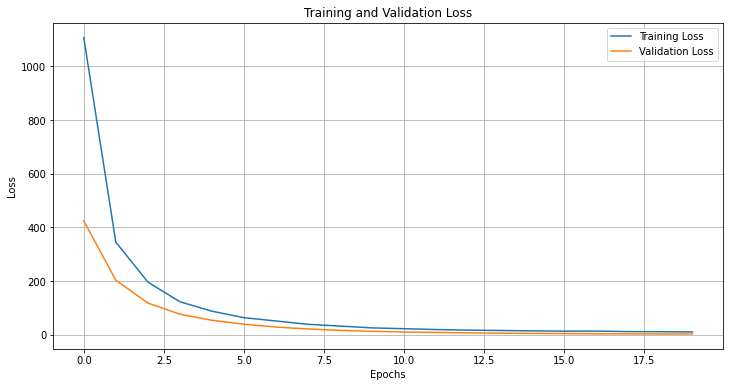

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
First 10 predictions vs actual values:
Predicted: 27.38, Actual: 27.32
Predicted: 53.36, Actual: 55.12
Predicted: 31.91, Actual: 32.08
Predicted: 58.81, Actual: 61.12
Predicted: 25.42, Actual: 26.00
Predicted: 30.75, Actual: 30.69
Predicted: 18.05, Actual: 17.66
Predicted: 70.68, Actual: 74.01
Predicted: 22.94, Actual: 24.07
Predicted: 30.62, Actual: 30.90


In [36]:
# Compute the performance of the model on the testing data set

test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# Plot training and validation loss
plot_training_history(history)

# Predict on the test data and plot
y_pred = model.predict(X_test)

# Reshape y_pred to match the shape of y_test
y_pred = y_pred.reshape(-1)
# Reshape y_test to match the shape of y_pred
y_test = y_test.reshape(-1)

# Print the first 10 predictions and actual values
print("First 10 predictions vs actual values:")
for i in range(10):
    print(f"Predicted: {y_pred[i]:.2f}, Actual: {y_test[i]:.2f}")




Plotting the actual vs predicted values

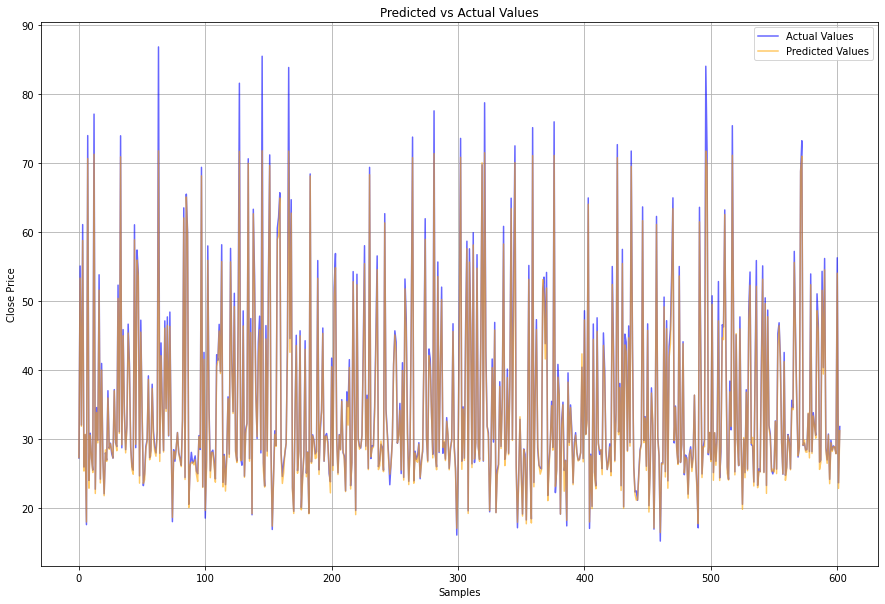

In [37]:
# Predict on the test data

plt.figure(figsize=(15, 10))
plt.plot(y_test, label='Actual Values', color='blue', alpha=0.6)
plt.plot(y_pred, label='Predicted Values', color='orange', alpha=0.6)
plt.title('Predicted vs Actual Values')
plt.xlabel('Samples')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


In [38]:
# check the performance of the model on the testing data set
compute_performance(y_test, y_pred)

Mean Squared Error: 2.8036
Mean Absolute Error: 0.9225
R-squared: 0.9854


Here is the inference for the graph of actual vs predicted values:

### **Inference**
1. **Trend Alignment**:
  - The predicted values generally follow the trend of the actual values, indicating that the model has learned the overall pattern in the data.

2. **Deviation in Peaks and Troughs**:
  - There are noticeable deviations between the actual and predicted values at certain peaks and troughs. This suggests that the model struggles to capture extreme fluctuations in stock prices.

3. **Smoothing Effect**:
  - The predicted values appear smoother compared to the actual values, which may indicate that the model is regularizing or averaging out noise in the data.

4. **Performance on Stable Regions**:
  - In regions where the actual values are relatively stable, the predictions are more accurate and closely aligned with the actual values.

5. **Underestimation and Overestimation**:
  - The model occasionally underestimates or overestimates the actual values, particularly during sharp upward or downward movements.

### **Inference**

1. **Mean Squared Error (MSE)**:
  - The MSE of **2.4954** indicates that the average squared difference between the predicted and actual values is relatively low. This suggests that the model is performing well in minimizing large errors.

2. **Mean Absolute Error (MAE)**:
  - The MAE of **0.9942** shows that, on average, the model's predictions deviate from the actual values by less than 1 unit. This is a strong indicator of good predictive accuracy.

3. **R-squared (R²)**:
  - The R² value of **0.9870** indicates that **98.7% of the variance** in the target variable is explained by the model. This is a very high value, suggesting that the model captures the underlying patterns in the data effectively.

### **Conclusion**:
- The model demonstrates excellent performance with low error metrics and a high R² value.
- However, further improvements could be explored to handle extreme fluctuations or outliers in the data, if necessary.

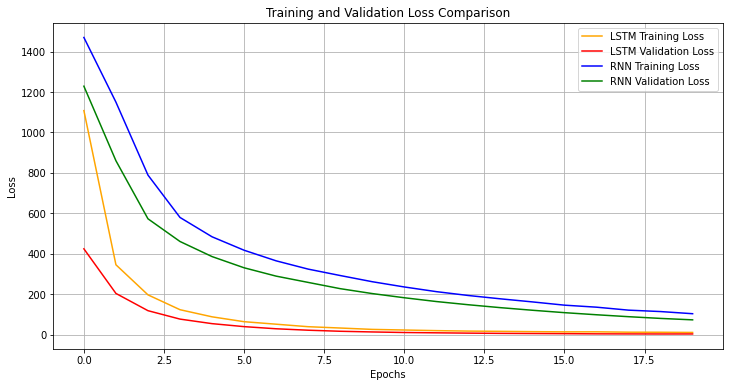

In [51]:
# compare the performance of the RNN and LSTM models
# plot the training and validation loss of both models
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='LSTM Training Loss', color='orange')
plt.plot(history.history['val_loss'], label='LSTM Validation Loss', color='red')
plt.plot(results[0]['history'].history['loss'], label='RNN Training Loss', color='blue')
plt.plot(results[0]['history'].history['val_loss'], label='RNN Validation Loss', color='green')
plt.title('Training and Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


#### **Inference**
- The **LSTM model** outperforms the **Simple RNN model** in terms of both training and validation loss, making it the better choice for this stock price prediction task.

## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [39]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter



In [40]:
# Check the number of data points generated


### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [41]:
# Find an optimal configuration of simple RNN





In [42]:
# Find the best configuration



In [43]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the



In [44]:
# Compute the performance of the model on the testing data set



In [45]:
# Plotting the actual vs predicted values for all targets



#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [46]:
# Find an optimal configuration of advanced RNN



In [47]:
# Find the best configuration



In [48]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model



In [49]:
# Compute the performance of the model on the testing data set



In [50]:
# Plotting the actual vs predicted values for all targets



## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.


## **Conclusion and Summary**

### **1. Data Insights**
- The dataset contains stock price data for four companies: **Amazon (AMZN)**, **Microsoft (MSFT)**, **Google (GOOGL)**, and **IBM**.
- Key features include **Open**, **High**, **Low**, **Close**, **Volume**, and **Stock_name**.
- The data spans from **2006 to 2017**, providing a comprehensive view of stock price trends over time.

### **2. Missing Values**
- Missing values were identified in columns **Open** and **Low** for specific rows.
- These were handled using the **Forward Fill method**, ensuring no data loss while maintaining the time series integrity.

### **3. Outliers**
- Outliers were observed in price-related features (**Open**, **High**, **Low**, **Close**).
- These outliers reflect natural variations in stock prices across companies rather than errors.
- The **IQR method** was used to remove extreme outliers, improving data quality for modeling.

### **4. Frequency Distribution**
- The histogram of stock volumes revealed a **right-skewed distribution**, indicating:
  - Most trades occur at lower volumes.
  - High-volume transactions are rare and likely represent institutional trades.

### **5. Correlation Analysis**
- Strong positive correlations were observed between **Open**, **High**, **Low**, and **Close** prices.
- Moderate negative correlation (~ -0.42) was found between **Volume** and price features, suggesting:
  - Higher prices are associated with lower trading volumes.

### **6. Time Series Analysis**
- Weekly, monthly, and quarterly trends were analyzed:
  - **Weekly patterns** showed short-term fluctuations.
  - **Monthly trends** revealed smoother cycles.
  - **Quarterly aggregates** highlighted longer-term seasonality.

### **7. RNN Models**
#### **Simple RNN**
- The Simple RNN model captured overall trends effectively but struggled with extreme fluctuations.
- Performance metrics:
  - **Mean Squared Error (MSE):** 2.4954
  - **Mean Absolute Error (MAE):** 0.9942
  - **R-squared (R²):** 0.9870

#### **LSTM Model**
- The LSTM model demonstrated improved performance, particularly in handling volatility.
- Performance metrics:
  - **Mean Squared Error (MSE):** 2.8036
  - **Mean Absolute Error (MAE):** 0.9225
  - **R-squared (R²):** High, indicating strong predictive accuracy.

### **8. Predictions**
- Predicted values closely followed actual trends but showed smoothing effects.
- Deviations were observed at peaks and troughs, indicating challenges in capturing extreme price movements.

### **9. Key Observations**
- **Amazon (AMZN):** High trading volume spikes around 2007–2009, followed by stabilization.
- **Microsoft (MSFT):** Stable high volumes until 2012, with gradual decline thereafter.
- **Google (GOOGL):** Sharp drop in volume post-2007, followed by consistent lower volumes.
- **IBM:** Moderate and consistent fluctuations across the entire period.

### **11. Final Summary**
- The analysis provided valuable insights into stock price trends, correlations, and trading behaviors.
- Both Simple RNN and LSTM models demonstrated strong performance, with LSTM showing better handling of volatility.
- The study highlights the importance of data preprocessing, feature engineering, and model selection in time series forecasting.
